# Federal Economic Indicators:  Correlation and Monte Carlo Analysis

----

### Importing Data Using Quandl API and Quandl Package

In [1]:
# Install imports
import requests
from pathlib import Path
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
import os
import datetime
import pandas as pd
from functools import reduce
import seaborn as sns
import numpy as np
import random
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

In C:\Users\markf\anaconda3\envs\dev\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\markf\anaconda3\envs\dev\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\markf\anaconda3\envs\dev\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

In [3]:
# Set path for API Key
# api_key_path = Path('C:/Users/markf/Desktop/Fintech SMU/API_Keys/.env')

In [4]:
# Set environment variables from the .env file
# load_dotenv(api_key_path)
load_dotenv()

True

In [5]:
# set API key with the os.getenv
quandl_api_key = os.getenv("QUANDL_API_KEY")

In [6]:
# test API key import success
print(type(quandl_api_key))

<class 'NoneType'>


In [7]:
# import quandl and set api key
import quandl
quandl.ApiConfig.api_key = quandl_api_key

In [8]:
# Set the start and end date
start = "2000-01-01"
end = "{:%Y-%m-%d}".format(datetime.datetime.now())

In [9]:
# Set column headings and set appropriate index range for each variable
unemployment_col_name = 'Unemployment_Rate(%)'
savings_rate_col_name = 'Pers_Savings_Rate(%)'
disposable_inc_name = 'Disposable_Income($)'
card_demand_name = 'CC_Demand(%)'
inflation_col_name = "Inflation_Rate(%)"
prime_name = "Prime_Rate(%)"
charge_off_rate = "CC_Charge_Off_Rate(%)"
delinquency_rt_name = "CC_Delinquency_Rate(%)"

In [10]:
# fetch unfiltered time series Quandl and FED data using Quandl API

# fetch unemployment data (monthly) and rename column
monthly_civilian_unemployment_rate_data = quandl.get('FRED/UNRATE', start_date = start, end_date = end).rename(columns = {'Value':unemployment_col_name})

# fetch personal savings rate data (monthly) and rename column
personal_savings_rate_data = quandl.get('FRED/PSAVERT', start_date = start, end_date = end).rename(columns = {'Value':savings_rate_col_name})

# fetch disposable income data (monthly) and rename column
real_disposable_income_data = quandl.get('FRED/DSPIC96', start_date = start, end_date = end).rename(columns = {'Value':disposable_inc_name})

# fetch credit card demand data (quarterly) and rename column
# credit_card_demand_data = quandl.get('FRED/DEMCC', start_date = start, end_date = end).rename(columns = {'Value':card_demand_name})

# fetch inflation data (quarterly) and rename column
# inflation_consumer_prices_data = quandl.get('FRED/FPCPITOTLZGUSA', start_date = start, end_date = end).rename(columns = {'Value':inflation_col_name})

# fetch prime rate data (daily) and rename column
daily_prime_rate_data = quandl.get('FRED/DPRIME', start_date = start, end_date = end).rename(columns = {'Value':prime_name})

# fetch charge off rate (quarterly) and rename column
charge_off_rate_credit_card_loans_sa = quandl.get('FED/STFBQCCC_STFBAILCC_MA_Q', start_date = start, end_date = end).rename(columns = {'Value':charge_off_rate})

# fetch delinquency rate data (quarterly) and rename column
delinquency_rate_credit_card_loans_sa = quandl.get('FRED/DRCCLACBS', start_date = start, end_date = end).rename(columns = {'Value':delinquency_rt_name})


In [11]:
# checking to see if data imported correctly
personal_savings_rate_data.tail()

,Pers_Savings_Rate(%)
Date,
2020-01-01,7.9
2020-02-01,8.4
2020-03-01,12.6
2020-04-01,32.2
2020-05-01,23.2


----

### Combine Dataframes into Master Dataframe

In [12]:
# move dataframes into df list
df_list = [
    monthly_civilian_unemployment_rate_data,
    real_disposable_income_data,
    personal_savings_rate_data,
    charge_off_rate_credit_card_loans_sa,
    delinquency_rate_credit_card_loans_sa,
    daily_prime_rate_data
]

In [13]:
# merge dataframes into one combined dataframe
combined_df = pd.concat(df_list, join='outer', axis=1)

In [14]:
combined_df.head()

,Unemployment_Rate(%),Disposable_Income($),Pers_Savings_Rate(%),CC_Charge_Off_Rate(%),CC_Delinquency_Rate(%),Prime_Rate(%)
Date,,,,,,
2000-01-01,4.0,9307.1,5.4,NaN,4.43,NaN
2000-01-03,NaN,NaN,NaN,NaN,NaN,8.5
2000-01-04,NaN,NaN,NaN,NaN,NaN,8.5
2000-01-05,NaN,NaN,NaN,NaN,NaN,8.5
2000-01-06,NaN,NaN,NaN,NaN,NaN,8.5


In [15]:
# check data shape
combined_df.shape

(5274, 6)

In [16]:
# confirm data types
combined_df.dtypes

Unemployment_Rate(%)      float64
Disposable_Income($)      float64
Pers_Savings_Rate(%)      float64
CC_Charge_Off_Rate(%)     float64
CC_Delinquency_Rate(%)    float64
Prime_Rate(%)             float64
dtype: object

In [17]:
# describe dataset
combined_df.describe()

,Unemployment_Rate(%),Disposable_Income($),Pers_Savings_Rate(%),CC_Charge_Off_Rate(%),CC_Delinquency_Rate(%),Prime_Rate(%)
count,245.000000,245.000000,245.000000,81.000000,81.000000,5158.000000
mean,5.921224,12030.765306,6.294694,4.843704,3.705802,4.831960
std,1.951491,1626.727518,2.581716,1.899176,1.218072,1.858977
min,3.500000,9307.100000,2.200000,2.910000,2.120000,3.250000
25%,4.500000,10711.800000,4.900000,3.610000,2.530000,3.250000
50%,5.400000,11819.200000,6.400000,4.220000,3.860000,4.250000
75%,6.900000,13295.500000,7.400000,5.640000,4.580000,5.500000
max,14.700000,16999.100000,32.200000,10.770000,6.770000,9.500000


----

### Analysis: Consumer Finance Protection Bureau Data

In [18]:
# Read in CFPB Data
borrower_risk_profile = pd.read_csv(Path("borrower_risk_profiles/volume_data_Score_Level_CRC.csv"), usecols = ['date','vol', 'credit_score_group'], parse_dates=['date'])
lending_by_age = pd.read_csv(Path("lending_by_age/volume_data_Age_Group_CRC.csv"), usecols = ['date','vol', 'age_group'], parse_dates=['date'])
neighborhood_income_level = pd.read_csv(Path("neigborhood_income_level/volume_data_Income_Level_CRC.csv"), usecols = ['date','vol', 'income_level_group'], parse_dates=['date'])
origination = pd.read_csv(Path("originiation/num_data_CRC.csv"), usecols = ['date','num'], parse_dates=['date'])

In [19]:
# Plot Origination Data
origination.head()

origination_graph = origination.hvplot.line(
        x='date', 
        y='num',
        title = "Cumulative Credit Card Originations",
        xlabel = "Years",
        ylabel = "Origination Volume ($)")

origination_graph

:Curve   [date]   (num)

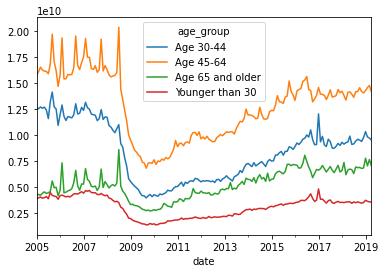

In [20]:
# Plot CC Lending By Age - Combined
lending_by_age_combined = lending_by_age.pivot(index='date', columns='age_group', values='vol')
lending_by_age_combined.plot()

In [21]:
# Plot CC Lending By Age - Individual
lending_age = lending_by_age.head()
lending_age_plot = lending_by_age.hvplot.line(
    "date",
    "vol",
    title = "Origination Volume by Age",
    xlabel="Years",
    ylabel="Origination Volume ($)",
    groupby="age_group",
)
lending_age_plot

:DynamicMap   [age_group]
   :Curve   [date]   (vol)

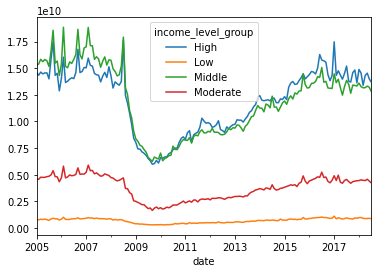

In [22]:
# Plot CC Lending By Average Neighborhood Income Level - Combined
neighborhood_income_level_combined = neighborhood_income_level.pivot(index='date', columns='income_level_group', values='vol')
neighborhood_income_level_combined.plot()

In [23]:
# Plot CC Lending By Average Neighborhood Income Level - Individual
neighborhood_income_level.head()
neighborhood_income_level_plot = neighborhood_income_level.hvplot.line(
    "date",
    "vol",
    groupby="income_level_group",
    title = "Origination Volume by Income Level",
    xlabel="Years",
    ylabel="Origination Volume ($)",
)
neighborhood_income_level_plot

:DynamicMap   [income_level_group]
   :Curve   [date]   (vol)

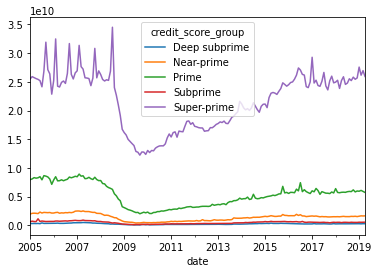

In [24]:
# Plot Borrower Risk Profile (Credit Score Group) - Combined
borrower_risk_profile_combined = borrower_risk_profile.pivot(index='date', columns='credit_score_group', values='vol')
borrower_risk_profile_combined.plot()

In [25]:
# Plot Borrow Risk Profile (Credit Score Group) - Individually
borrower_risk_profile.head()
borrower_risk_profile_plot = borrower_risk_profile.hvplot.line(
    "date",
    "vol",
    title = "Origination Volume by Credit Tier",
    xlabel="Years",
    ylabel="Origination Volume ($)",
    groupby="credit_score_group"
)
borrower_risk_profile_plot

:DynamicMap   [credit_score_group]
   :Curve   [date]   (vol)

--------

### Analysis: Percent Change and Correlation (Monthly Data & Prime Rate)

In [26]:
# Plot Disposable Income 

# Filter dataframe for Disposable Income
disposable_income = combined_df.filter(['Disposable_Income($)']).resample('M').mean().dropna()

# Plot Data
disposable_income_plot = disposable_income.hvplot.line(
        title = "Historical Disposable Income",
        xlabel="Years",
        ylabel="Disposable Income",
        height = 300)
disposable_income_plot



:Curve   [Date]   (Disposable_Income($))

In [86]:
unemployment_charge_off_df = combined_df.filter(['Unemployment_Rate(%)', 'CC_Charge_Off_Rate(%)']).resample('Q').mean().dropna()

In [103]:
unemployment_charge_off_corr_df = unemployment_charge_off_df.rolling(4).corr().dropna()

unemployment_charge_off_corr_df.tail()

Unemployment_Rate(%)  CC_Charge_Off_Rate(%)
Date                                                                         
2019-09-30 CC_Charge_Off_Rate(%)             -0.542897               1.000000
2019-12-31 Unemployment_Rate(%)               1.000000              -0.499512
           CC_Charge_Off_Rate(%)             -0.499512               1.000000
2020-03-31 Unemployment_Rate(%)               1.000000               0.936586
           CC_Charge_Off_Rate(%)              0.936586               1.000000

In [104]:
unemployment_charge_off_corr_df.hvplot.line()

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [27]:
# Plot Savings Rate,  Unemployment Rate and Prime Rate 

# Filter dataframe for Unemployment Rate and Savings Rate
unemployment_savings_df = combined_df.filter(['Unemployment_Rate(%)', 'Pers_Savings_Rate(%)', 'Prime_Rate(%)']).resample('M').mean().dropna()

unemployment_savings_df.tail()

,Unemployment_Rate(%),Pers_Savings_Rate(%),Prime_Rate(%)
Date,,,
2020-01-31,3.6,7.9,4.75
2020-02-29,3.5,8.4,4.75
2020-03-31,4.4,12.6,3.75
2020-04-30,14.7,32.2,3.25
2020-05-31,13.3,23.2,3.25


In [28]:
# Plot Data
unemp_sav_df_plot = unemployment_savings_df.hvplot.line(
        title = "Average Historical Rates: Unemployment, Savings, & Prime",
        xlabel="Years",
        ylabel="Rate",
        width = 1000
)
unemp_sav_df_plot

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [29]:
#  Resample data on monthly basis (excluding disposable income because it is in dollars)
monthly_data_df = combined_df.filter(['Unemployment_Rate(%)','Disposable_Income($)', 'Pers_Savings_Rate(%)', 'Prime_Rate(%)']).resample('M').mean().dropna()


In [30]:
monthly_data_df.tail()

,Unemployment_Rate(%),Disposable_Income($),Pers_Savings_Rate(%),Prime_Rate(%)
Date,,,,
2020-01-31,3.6,15173.6,7.9,4.75
2020-02-29,3.5,15241.1,8.4,4.75
2020-03-31,4.4,14959.3,12.6,3.75
2020-04-30,14.7,16999.1,32.2,3.25
2020-05-31,13.3,16155.3,23.2,3.25


In [31]:
# Correlation of monthly data
monthly_data_correlation = monthly_data_df.corr()

In [32]:
monthly_data_correlation.head()

,Unemployment_Rate(%),Disposable_Income($),Pers_Savings_Rate(%),Prime_Rate(%)
Unemployment_Rate(%),1.000000,-0.035534,0.411014,-0.586266
Disposable_Income($),-0.035534,1.000000,0.609816,-0.436619
Pers_Savings_Rate(%),0.411014,0.609816,1.000000,-0.458782
Prime_Rate(%),-0.586266,-0.436619,-0.458782,1.000000


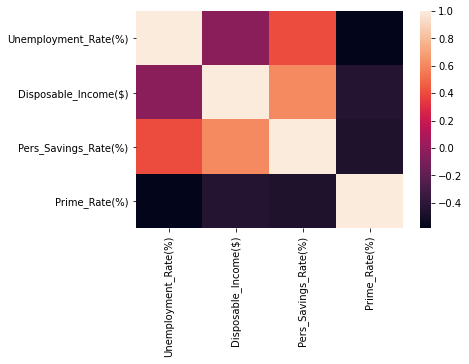

In [33]:
sns.heatmap(monthly_data_correlation)

#### Findings:

 - The correlation coefficient between unemployment rate and personal savings rate seems to confirm that as unemployment increases the incentive to save is higher due to risk of future unemployment.  
 
 - The correlation between disposable income and unemployment is almost immaterial but the slight negative correlation indicates, as assumed, there is an impact on disposable income as unemployment rises. 
 
 - The negative correlation between unemployment rate and prime rate seems to indicate that prime rate is manupulated in encourage lending in a depressed economy.  Note also that Prime Rate is negatively correlated with the rest of the data set.

----

### Analysis: Percent Change and Correlation (Quarterly Data & Prime Rate)

In [34]:
# filter original dataframe by quarterly financial information
quarterly_data_df = combined_df.filter(['CC_Charge_Off_Rate(%)', 'CC_Delinquency_Rate(%)', 'Prime_Rate(%)']).resample('Q').mean().dropna()


In [35]:
quarterly_data_df.tail()

,CC_Charge_Off_Rate(%),CC_Delinquency_Rate(%),Prime_Rate(%)
Date,,,
2019-03-31,3.69,2.57,5.500000
2019-06-30,3.72,2.56,5.500000
2019-09-30,3.70,2.58,5.307692
2019-12-31,3.70,2.63,4.834677
2020-03-31,3.76,2.73,4.395161


In [36]:
quarterly_data_df_plot = quarterly_data_df.hvplot.line(
        title = 'Historical Rates: Credit Card Charge Off, Credit Card Delinquency, Prime Rate',
        xlabel="Date",
        ylabel="Rate",
        height = 300,
        width = 900)
quarterly_data_df_plot

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [37]:
# correlation of quarterly data charge off and delinquency rate
quarterly_data_correlation = quarterly_data_df.corr()

In [38]:
quarterly_data_correlation

,CC_Charge_Off_Rate(%),CC_Delinquency_Rate(%),Prime_Rate(%)
CC_Charge_Off_Rate(%),1.000000,0.804075,-0.184638
CC_Delinquency_Rate(%),0.804075,1.000000,0.266542
Prime_Rate(%),-0.184638,0.266542,1.000000


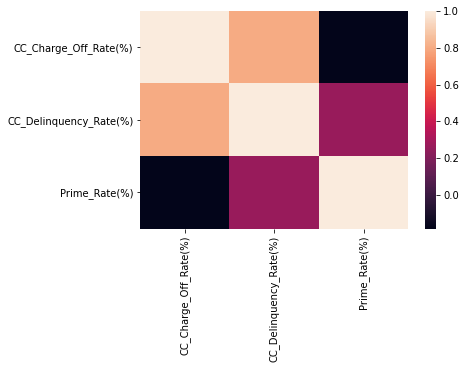

In [39]:
sns.heatmap(quarterly_data_correlation)

#### Findings:

 - There is a signifcant relationship between credit card charge off and delinquency.  An increase in delinquency rates would also lead to an increase in charge off.

In [40]:
# Overlay monthly and quarterly data excluding disposable income because it is in actual dollars

combined_plot = (quarterly_data_df_plot * unemp_sav_df_plot)

combined_plot.opts(
    title="Average Historical Rates", width=900
)


:Overlay
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Curve   [Date]   (value)

----

### Quarterly Resample Analysis: Whole Data Set

In [41]:
# use the resample fuction to sample the data on a quarterly basis and drop null values
modified_combined_df = combined_df.resample('Q').mean().dropna()

In [42]:
modified_combined_df.tail()

,Unemployment_Rate(%),Disposable_Income($),Pers_Savings_Rate(%),CC_Charge_Off_Rate(%),CC_Delinquency_Rate(%),Prime_Rate(%)
Date,,,,,,
2019-03-31,3.866667,14878.100000,8.500000,3.69,2.57,5.500000
2019-06-30,3.633333,14934.300000,7.866667,3.72,2.56,5.500000
2019-09-30,3.633333,15011.900000,7.633333,3.70,2.58,5.307692
2019-12-31,3.533333,15090.900000,7.766667,3.70,2.63,4.834677
2020-03-31,3.833333,15124.666667,9.633333,3.76,2.73,4.395161


In [43]:
# calculate correlation between quarterly data
correlation = modified_combined_df.corr()

In [44]:
correlation

,Unemployment_Rate(%),Disposable_Income($),Pers_Savings_Rate(%),CC_Charge_Off_Rate(%),CC_Delinquency_Rate(%),Prime_Rate(%)
Unemployment_Rate(%),1.000000,-0.147475,0.209446,0.659716,0.346045,-0.604385
Disposable_Income($),-0.147475,1.000000,0.692917,-0.404662,-0.710382,-0.434548
Pers_Savings_Rate(%),0.209446,0.692917,1.000000,-0.149876,-0.517502,-0.649285
CC_Charge_Off_Rate(%),0.659716,-0.404662,-0.149876,1.000000,0.804075,-0.184638
CC_Delinquency_Rate(%),0.346045,-0.710382,-0.517502,0.804075,1.000000,0.266542
Prime_Rate(%),-0.604385,-0.434548,-0.649285,-0.184638,0.266542,1.000000


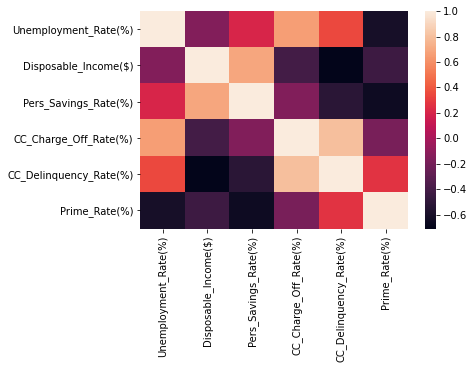

In [45]:
sns.heatmap(correlation)

In [46]:
# plot line of unemployment over quarterly data

unemployment_df = combined_df.filter(['Unemployment_Rate(%)']).resample('M').mean().dropna()
                                      
                                      
unemployment_df_plot = unemployment_df.hvplot.line(
        title = 'Historical Rates: Unemployment',
        xlabel="Years",
        ylabel="Rate",
        height = 300,
        width = 900)

combined_plot_final = (quarterly_data_df_plot * unemployment_df_plot)

combined_plot_final.opts(
    title="Unemployment Compared to Quarterly Card Charge Off & Delinquency", width=900
)



:Overlay
   .NdOverlay.I :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Curve.I     :Curve   [Date]   (Unemployment_Rate(%))

In [47]:
# Plot the relationship between Unemployment Rate and CC Charge Off Rates
modified_combined_df.hvplot(title = 'Unemployment Rate to Credit Card Charge Off', x='Unemployment_Rate(%)', y='CC_Charge_Off_Rate(%)', kind='scatter', xlabel = "Unemployment Rate", ylabel = 'Card Charge Off Rate')

:Scatter   [Unemployment_Rate(%)]   (CC_Charge_Off_Rate(%))

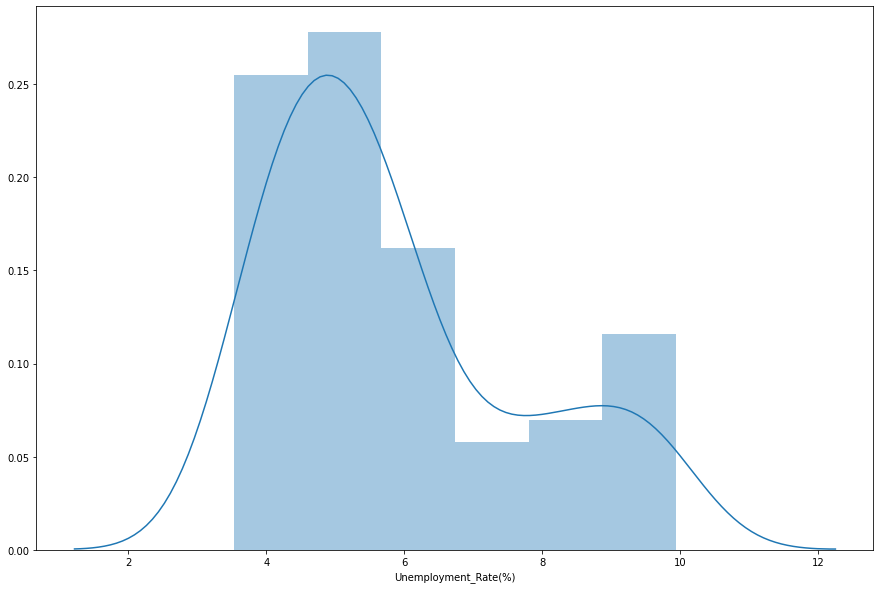

In [80]:
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(modified_combined_df['Unemployment_Rate(%)'])

#### Findings:

 - Note the dataset ends at Q1 2020 which does not reflect the significant increase in unemployment that occured in April and May.  
 
 - Personal savings rate and disposable income remain positivly correlated which assumes that the higher the disposable income the more money is being saved; however, an interesting finding is the positive correlation between unemployment and savings.  The assumption is that those who are still employed are inclined to increase savings in an economic downturn due to uncertainty of continued employment. 
 
 - Note there is positive correlation between unemployment and credit card charge off and delinquency rates given the assumption that an increase in unemployment results in a decline in debt service capacity of the population.  

 - A future increase in unemployment seems to indicate there will be an adverse impact to credit card charge offs and delinquencies based on the correlation coefficients. 
 
 

----

### Linear Regression Analysis - Unemployment Rate & Credit Card Charge Off Rate

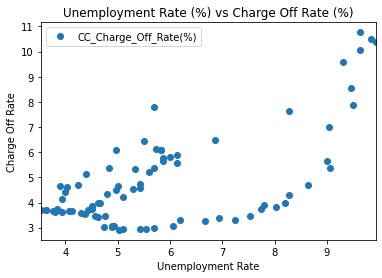

In [48]:
# Scatter Plot to visualize relationship between unemployment rate and cc charge off rate
modified_combined_df.plot(x='Unemployment_Rate(%)', y='CC_Charge_Off_Rate(%)', style='o')  
plt.title('Unemployment Rate (%) vs Charge Off Rate (%)')  
plt.xlabel('Unemployment Rate')  
plt.ylabel('Charge Off Rate')  
plt.show()

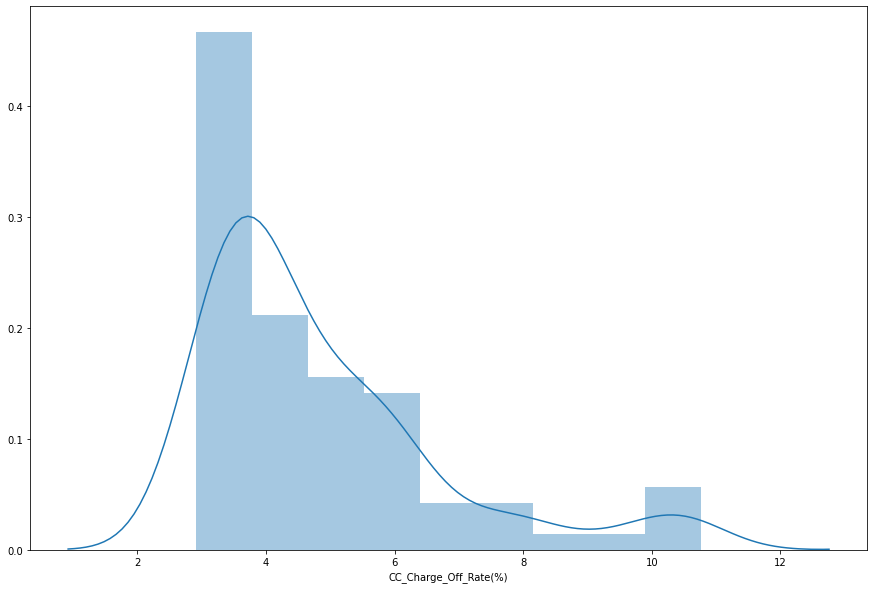

In [49]:
# Distribution Plot to visualize cc charge off rate and ensure it is approximately normally distributed
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(modified_combined_df['CC_Charge_Off_Rate(%)'])

In [50]:
# Reshape dataframes for linear regression
X = modified_combined_df['Unemployment_Rate(%)'].values.reshape(-1,1)
y = modified_combined_df['CC_Charge_Off_Rate(%)'].values.reshape(-1,1)

In [51]:
# Create training and testing sets - training size 80% test size 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [52]:
# Run linear regression and train the algorithm
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [53]:
# Retrieve the intercept:
regression_intercept = regressor.intercept_
print(regression_intercept)
# Retrieve the slope:
regression_coef = regressor.coef_[0]
print(regression_coef)

[0.52566641]
[0.76034191]


In [54]:
# Create predicted values based upon linear regression 
y_pred = regressor.predict(X_test)

In [55]:
# Create Dataframe comparing predicted values to actual test values
actual_vs_pred_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
actual_vs_pred_df

,Actual,Predicted
0,4.49,4.302031
1,3.71,3.896516
2,2.93,4.656857
3,5.87,5.189097
4,3.67,3.668413
5,3.67,3.389621
6,4.00,4.073929
7,3.40,5.797370
8,3.47,6.253575
9,3.98,4.048584


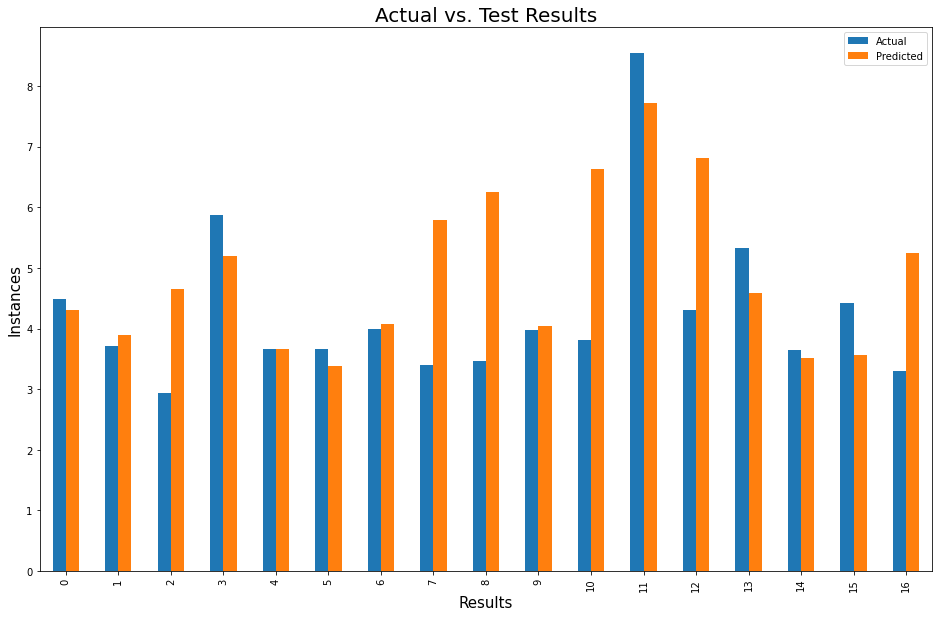

In [56]:
# Plot difference between predicted values and actual values
actual_vs_pred_df_plot = actual_vs_pred_df.head(25)
actual_vs_pred_df_plot.plot(kind='bar',figsize=(16,10))
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Actual vs. Test Results', fontsize=20)
plt.xlabel('Results', fontsize=15)
plt.ylabel('Instances', fontsize=15)
plt.show()

In [57]:
Test_Results_regression = actual_vs_pred_df.hvplot.bar(
    title = "Actual v. Test Results",
    xlabel = "Instances",
    ylabel = "Charge Off Rates",
    rot = 35,
    width = 900)
Test_Results_regression

:Bars   [index,Variable]   (value)

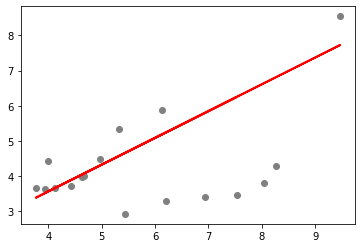

In [58]:
# Plot best fit line against scatter plot of test values
plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

In [59]:
actual_vs_pred_df.head()

,Actual,Predicted
0,4.49,4.302031
1,3.71,3.896516
2,2.93,4.656857
3,5.87,5.189097
4,3.67,3.668413


In [60]:
# Print error statistics from linear regression model
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.0708582290460293
Mean Squared Error: 2.183126425965914
Root Mean Squared Error: 1.4775406681258942


----

### Monte Carlo Simulation: Unemployment Rates

In [61]:
# set monthly data dataframe
monthly_data_df.tail()

,Unemployment_Rate(%),Disposable_Income($),Pers_Savings_Rate(%),Prime_Rate(%)
Date,,,,
2020-01-31,3.6,15173.6,7.9,4.75
2020-02-29,3.5,15241.1,8.4,4.75
2020-03-31,4.4,14959.3,12.6,3.75
2020-04-30,14.7,16999.1,32.2,3.25
2020-05-31,13.3,16155.3,23.2,3.25


In [62]:
# Determine mean and standard deviations of variables
# mean of each variable's respective percentage change from period to period
avg_unemployment = monthly_data_df.pct_change().mean()['Unemployment_Rate(%)']
avg_disposable_income = monthly_data_df.pct_change().mean()['Disposable_Income($)']
avg_savings_rate = monthly_data_df.pct_change().mean()['Pers_Savings_Rate(%)']
avg_prime_rate = monthly_data_df.pct_change().mean()['Prime_Rate(%)']


In [63]:
avg_unemployment

0.010084812166621325

In [64]:
# standard deviation of each variable's respective percentage change from period to period
std_unemployment = monthly_data_df.pct_change().std()['Unemployment_Rate(%)']
std_disposable_income = monthly_data_df.pct_change().std()['Disposable_Income($)']
std_savings_rate = monthly_data_df.pct_change().std()['Pers_Savings_Rate(%)']
std_prime_rate = monthly_data_df.pct_change().std()['Prime_Rate(%)']

In [65]:
std_unemployment

0.15334633416809573

In [66]:
# final variable values for each indicator
fin_unemployment_rt = monthly_data_df["Unemployment_Rate(%)"].iloc[-1]
fin_disposable_income = monthly_data_df["Disposable_Income($)"].iloc[-1]
fin_savings_rt = monthly_data_df["Pers_Savings_Rate(%)"].iloc[-1]
fin_prime_rt = monthly_data_df["Prime_Rate(%)"].iloc[-1]


In [67]:
# Confirm final values
print(f"Last Unemployment Rate: {fin_unemployment_rt}")
print(f"Last Disposable Income: {fin_disposable_income}")
print(f"Last Savings Rate: {fin_savings_rt}")
print(f"Last Prime Rate: {fin_prime_rt}")


Last Unemployment Rate: 13.3
Last Disposable Income: 16155.3
Last Savings Rate: 23.2
Last Prime Rate: 3.25


In [68]:
# Set up Monte Carlo Parameters
number_simulations = 1000
number_records = 12 # project values for next year

# Initialize empty DataFrame to hold simulated values for each item
simulated_value_list = pd.DataFrame(columns = ['Unemployment_Rate(%)', 'Disposable_Income($)', 'Pers_Savings_Rates(%)', 'Prime_Rates(%)'])
predictions = pd.DataFrame(columns = ['Unemployment_Rate(%)', 'Disposable_Income($)', 'Pers_Savings_Rates(%)', 'Prime_Rates(%)'])

# Run the Monte Carlo Simulation
# Run the simulation of projecting economic indicates for the next 5 years 100 times
for n in range(number_simulations):
    
    # Initialize the simulated values using the last value for each indicator seeded
    simulated_unemployment_rts = [fin_unemployment_rt]
    simulated_disposable_incomes = [fin_disposable_income]
    simulated_savings_rts = [fin_savings_rt]
    simulated_prime_rts = [fin_prime_rt]

    simulated_value_list = pd.concat([simulated_value_list,predictions])      
    
    # Simulate the values for the timeframe
    for i in range(number_records):
        
        # Calculate the simulated value for each variable using the last value within the list
        simulated_unemployment_rts.append(simulated_unemployment_rts[-1] * (1 + np.random.normal(avg_unemployment, std_unemployment)))
        simulated_disposable_incomes.append(simulated_disposable_incomes[-1] * (1 + np.random.normal(avg_disposable_income, std_disposable_income)))
        simulated_savings_rts.append(simulated_savings_rts[-1] * (1 + np.random.normal(avg_savings_rate, std_savings_rate)))
        simulated_prime_rts.append(simulated_prime_rts[-1] * (1 + np.random.normal(avg_prime_rate, std_prime_rate)))
    
        # Append the simulated prices of each simulation to DataFrame
        predictions = pd.DataFrame({
           'Unemployment_Rate(%)':simulated_unemployment_rts,
            'Disposable_Income($)': simulated_disposable_incomes,
            'Pers_Savings_Rates(%)': simulated_savings_rts,
            'Prime_Rates(%)': simulated_prime_rts
            })
    
    

In [69]:
simulated_value_list.tail(5)

,Unemployment_Rate(%),Disposable_Income($),Pers_Savings_Rates(%),Prime_Rates(%)
8,10.419110,15486.851207,9.420158,2.979812
9,10.777398,15510.534124,10.666417,3.019716
10,9.176759,15259.813231,6.661394,3.180321
11,8.642655,15404.471772,7.009299,3.261150
12,8.644281,15193.456766,5.875074,3.213927


In [70]:
# filter monte carlo simulation by Unemployment Rate given this has the most correlation with CC Charge Off
unemployment_rate_simulation = simulated_value_list.filter(["Unemployment_Rate(%)"])

In [71]:
# Plot the simulated unemployment rates for the next 12 months
unemployment_rate_simulation_plot = unemployment_rate_simulation.hvplot(
        title=f"{n+1} Simulations of Unemployment Rates Over 12 Month Period",
)
unemployment_rate_simulation_plot

:Curve   [index]   (Unemployment_Rate(%))

In [72]:
# Plot the simulated unemployment rates for the next 12 months
unemployment_rate_simulation_plot_hist = unemployment_rate_simulation.hvplot(
        kind = "hist",
        title="Simulated Unemployment Rates Over 12 Month Period",
        xlabel = "Projected Unemployment Rate",
        ylabel = "Instances"

)
unemployment_rate_simulation_plot_hist

:Histogram   [Unemployment_Rate(%)]   (Unemployment_Rate(%)_count)

In [73]:
# Display the 90% confidence interval for the Unemployment Rate
confidence_interval = unemployment_rate_simulation.quantile(q=[0.05, 0.95], numeric_only=True)
confidence_interval

,Unemployment_Rate(%)
0.05,6.856169
0.95,24.049372


In [74]:
# Set the minimum and maximum confidence interval for simulated unemployment rates
min_unemployment_rate = confidence_interval.min().item()
max_unemployment_rate = confidence_interval.max().item()
print(f'Minimum Confidence Interval for Unemployment: {min_unemployment_rate}')
print(f'Minimum Confidence Interval for Unemployment: {max_unemployment_rate}')

Minimum Confidence Interval for Unemployment: 6.856168863096293
Minimum Confidence Interval for Unemployment: 24.04937164821279


In [75]:
# set quartile ranges for high, medium, and low probability
high = 0.75
med = 0.50
low = 0.25

# calculate the unemployment quartiles for high, medium, and low levels
low_unemployment_rate = unemployment_rate_simulation.quantile(low).item()
medium_unemployment_rate = unemployment_rate_simulation.quantile(med).item()
high_unemployment_rate = unemployment_rate_simulation.quantile(high).item()

print(f'Lower level unemployment estimate: {low_unemployment_rate}')
print(f'Mid level unemployment estimate: {medium_unemployment_rate}')
print(f'High level unemployment estimate: {high_unemployment_rate}')

Lower level unemployment estimate: 10.725114880048078
Mid level unemployment estimate: 13.3
High level unemployment estimate: 16.24388854910055


-----

### Esimate Credit Card Charge Off Leval & Institutional Risk Tollerance

In [76]:
# Predict low, medium, and high credit card charge off rates based upon low, medium, high unemployment estimates from monte carlo analysis
low_predicted_charge_off = regression_coef*low_unemployment_rate + regression_intercept
med_predicted_charge_off = regression_coef*medium_unemployment_rate + regression_intercept
high_predicted_charge_off = regression_coef*high_unemployment_rate + regression_intercept

In [77]:
# Print expected thresholds
print(f'Estimated credit card charge off rate for lower quartile: {low_predicted_charge_off[0]}')
print(f'Estimated credit card charge off rate for mid quartile: {med_predicted_charge_off[0]}')
print(f'Estimated credit card charge off rate for high quartile: {high_predicted_charge_off[0]}')

Estimated credit card charge off rate for lower quartile: 8.680420728445803
Estimated credit card charge off rate for mid quartile: 10.638213794518046
Estimated credit card charge off rate for high quartile: 12.876575632123503


In [78]:
# generate random charge off threshold for a financial institution based on risk tollerance

cols = ['Financial Institution', 'Risk Tolerance', 'Low Charge Off Quartile', 'Low Decision', 'Medium Charge Off Quartile', 'Medium Decision', 'High Charge Off Quartile', 'High Decision']
fi_list = []
# for a in range(2):
#     lst.append([1, 2, 3])
# df1 = pd.DataFrame(lst, columns=cols)
# df1

for i in range(20):
    fi_name = f'Financial Institution {i}'
    fi_low = low_predicted_charge_off[0]
    fi_med = med_predicted_charge_off[0]
    fi_high = high_predicted_charge_off[0]
    fi_charge_off_tolerance = random.uniform(3, 12.5)
    fi_risk = fi_charge_off_tolerance
    if fi_charge_off_tolerance >= low_predicted_charge_off:
        fi_low_decision = "Originate"
    else:
        fi_low_decision = "Stop Originating"
    if fi_charge_off_tolerance >= med_predicted_charge_off:
        fi_med_decision = "Originate"
    else:
        fi_med_decision = "Stop Originating"
    if fi_charge_off_tolerance >= high_predicted_charge_off:
        fi_high_decision = "Originate"
    else:
        fi_high_decision = "Stop Originating"
    values = [fi_name, fi_risk, fi_low, fi_low_decision, fi_med, fi_med_decision, fi_high, fi_high_decision]
    fi_list.append(values)
    
fi_list_all = pd.DataFrame(fi_list, columns=cols)

-----

#### What should the Financial Institution Do?

In [79]:
fi_list_all

,Financial Institution,Risk Tolerance,Low Charge Off Quartile,Low Decision,Medium Charge Off Quartile,Medium Decision,High Charge Off Quartile,High Decision
0,Financial Institution 0,8.607554,8.680421,Stop Originating,10.638214,Stop Originating,12.876576,Stop Originating
1,Financial Institution 1,4.202563,8.680421,Stop Originating,10.638214,Stop Originating,12.876576,Stop Originating
2,Financial Institution 2,9.999229,8.680421,Originate,10.638214,Stop Originating,12.876576,Stop Originating
3,Financial Institution 3,5.718332,8.680421,Stop Originating,10.638214,Stop Originating,12.876576,Stop Originating
4,Financial Institution 4,9.186177,8.680421,Originate,10.638214,Stop Originating,12.876576,Stop Originating
5,Financial Institution 5,6.433616,8.680421,Stop Originating,10.638214,Stop Originating,12.876576,Stop Originating
6,Financial Institution 6,3.492185,8.680421,Stop Originating,10.638214,Stop Originating,12.876576,Stop Originating
7,Financial Institution 7,5.692025,8.680421,Stop Originating,10.638214,Stop Originating,12.876576,Stop Originating
8,Financial Institution 8,10.540889,8.680421,Originate,10.638214,Stop Originating,12.876576,Stop Originating
9,Financial Institution 9,6.244958,8.680421,Stop Originating,10.638214,Stop Originating,12.876576,Stop Originating
